<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/Ensemble_final_finito_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [4]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [5]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(3,3),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/315.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/315_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/315_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/317.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/317_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/318.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/318_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/319.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/319_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/319_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/320.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/320_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/321.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/321_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/322.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/322_1.jpg
/content/drive/My D

In [8]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [9]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test split

In [10]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.20,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [11]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [12]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [13]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [14]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [15]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(7, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [16]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [17]:
inp = Input(shape = (32,32,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [18]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])
"""
out = Dense(64,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)"""

"\nout = Dense(64,activation='relu')(out)\nout = Dropout(0.40)(out)\nout = Dense(128,activation='relu')(out)\nout = Dropout(0.45)(out)\nout = Dense(256,activation='relu')(out)\n#out = Dropout(0.50)(out)\n\n\noutput = Dense(8,activation='softmax')(out)"

In [19]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = out)

In [20]:
print("Feature extraction ...Training")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...Training


(5653, 480)

In [21]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [22]:
#print("Feature extraction ...validation")
#prediction_v = np.array(e_model.predict([x_te,x_te]))

#prediction_v.shape

In [23]:
#Xvalidate = np.reshape(prediction_v, (prediction_v.shape[0], prediction_v.shape[1]))

In [24]:
print("Feature extraction ...Testing")
prediction_tes = np.array(e_model.predict([x_te,x_te]))

Feature extraction ...Testing


In [25]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [26]:
print('\tFeatures training shape: ', Xtrain.shape)
#print('\tFeatures testing shape: ', Xvalidate.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (5653, 480)
	Features testing shape:  (1414, 480)


#### Decition Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

#### dt

In [29]:
dt=DecisionTreeClassifier(max_leaf_nodes=65,min_samples_split=8)

### SVM

In [36]:
svm = SVC(kernel='rbf',C=2154.4346900318824,gamma=0.1, probability=True)

### RF

In [37]:
rfc=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=8, criterion='entropy')

### KNN

In [38]:
knn=KNeighborsClassifier(n_neighbors=3)

In [39]:
eclf = VotingClassifier(estimators=[('dt', dt), ('svc', svm), ('rf', rfc),('knn',knn)],voting='soft', weights=[2, 5, 1, 1])

### using k fold

In [40]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = KFold(n_splits=3)

In [41]:
#dt=DecisionTreeClassifier(max_leaf_nodes=95,min_samples_split=6)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    eclf.fit(x_tr, y_trin)
    predicted_labels = eclf.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = eclf.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[   0    2    4 ... 5649 5651 5652] having : 3768
[   1    3    8 ... 5645 5648 5650] having : 1885
iteration 0
folds  1
[   1    2    3 ... 5649 5650 5651] having : 3769
[   0    4    7 ... 5643 5647 5652] having : 1884
iteration 1
folds  2
[   0    1    3 ... 5648 5650 5652] having : 3769
[   2    5    6 ... 5646 5649 5651] having : 1884
iteration 2


In [42]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

	Training Accuracy of ensemble: 0.9904


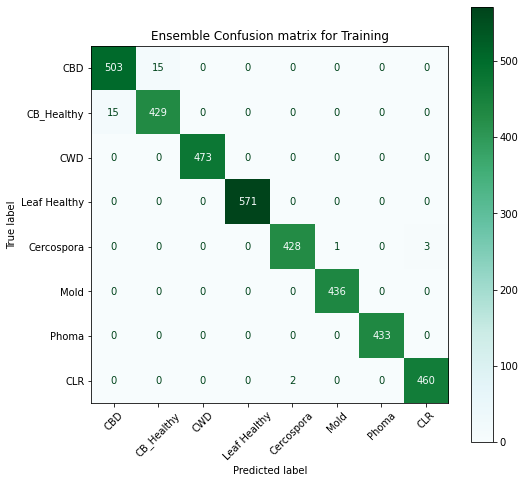

In [43]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of ensemble: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=eclf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Ensemble Confusion matrix for Training")
    plt.show()

	Testing Accuracy of ensemble: 0.9512


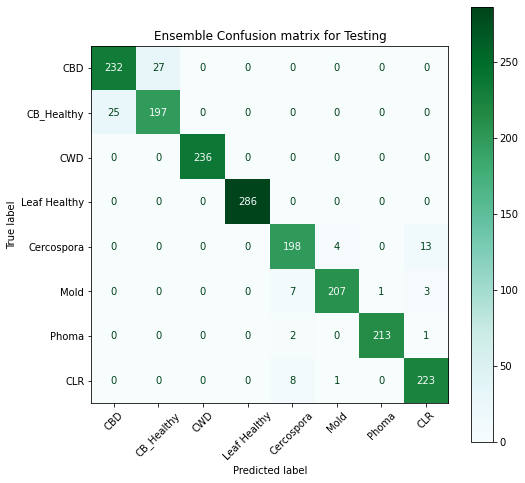

In [44]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tTesting Accuracy of ensemble: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=eclf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Ensemble Confusion matrix for Testing")
    plt.show()

In [45]:
print('classification report for ensemble on testing dataset')
print(classification_report(actual_targets,predicted_targets,target_names=target_names))

classification report for ensemble on testing dataset
              precision    recall  f1-score   support

         CBD       0.90      0.90      0.90       259
  CB_Healthy       0.88      0.89      0.88       222
         CWD       1.00      1.00      1.00       236
     Healthy       1.00      1.00      1.00       286
  Cercospora       0.92      0.92      0.92       215
        Mold       0.98      0.95      0.96       218
       Phoma       1.00      0.99      0.99       216
         CLR       0.93      0.96      0.94       232

    accuracy                           0.95      1884
   macro avg       0.95      0.95      0.95      1884
weighted avg       0.95      0.95      0.95      1884



In [46]:
result = eclf.predict(Xtest)
print('classification report for ensemble on testing dataset')
print(classification_report(y_te,result,target_names=target_names))

classification report for ensemble on testing dataset
              precision    recall  f1-score   support

         CBD       0.89      0.89      0.89       195
  CB_Healthy       0.87      0.87      0.87       166
         CWD       1.00      1.00      1.00       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.93      0.93      0.93       162
        Mold       0.98      0.98      0.98       164
       Phoma       1.00      0.99      0.99       162
         CLR       0.94      0.95      0.95       173

    accuracy                           0.95      1414
   macro avg       0.95      0.95      0.95      1414
weighted avg       0.95      0.95      0.95      1414



	Validation Accuracy of ensemble: 0.9533


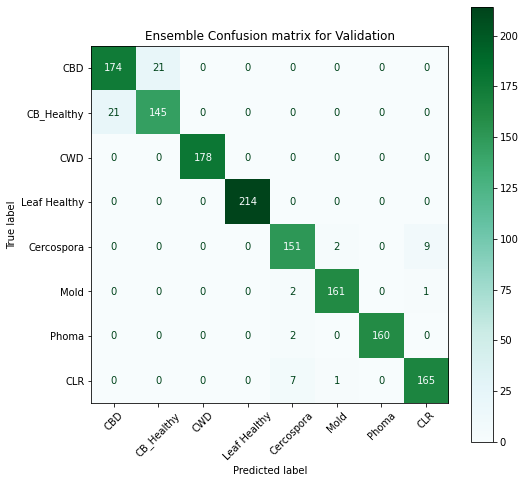

In [47]:
    acc = accuracy_score(result, np.ravel(y_te, order='C'))
    print("\tValidation Accuracy of ensemble: %0.4f" % acc)
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=eclf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Ensemble Confusion matrix for Validation")
    plt.show()

>Random Forest 0.867 (0.007)
>KNN 0.864 (0.010)
>DecisionTree 0.840 (0.008)
>SVM 0.956 (0.005)
>stacking 0.957 (0.006)


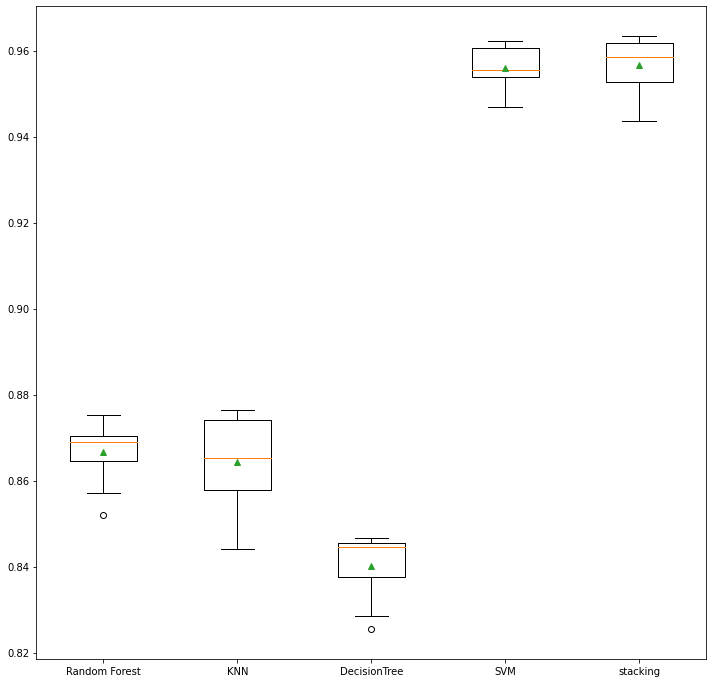

In [50]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get the dataset
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('rf', RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=8, criterion='entropy')))
	level0.append(('knn', KNeighborsClassifier(n_neighbors=3)))
	level0.append(('Dt', DecisionTreeClassifier(max_leaf_nodes=65,min_samples_split=8)))
	level0.append(('svm', SVC(kernel='rbf',C=2154.4346900318824,gamma=0.1, probability=True)))
	
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['Random Forest'] = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=8, criterion='entropy')
	models['KNN'] = KNeighborsClassifier(n_neighbors=3)
	models['DecisionTree'] = DecisionTreeClassifier(max_leaf_nodes=65,min_samples_split=8)
	models['SVM'] = SVC(kernel='rbf',C=2154.4346900318824,gamma=0.1, probability=True)

	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, Xtrain, y_tr)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.figure(figsize=(12,12))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

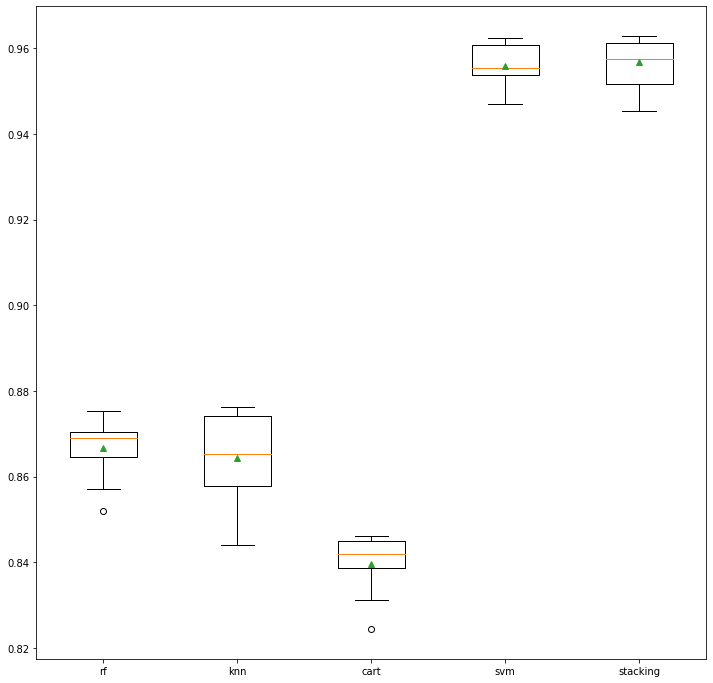

In [49]:
plt.figure(figsize=(12,12))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
for eclf, label in zip([dt, svm, rfc, knn], ['dt', 'svc', 'rf', 'knn']):
  scores = cross_val_score(eclf, Xtrain, y_tr, scoring='accuracy', cv=3)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))